---
<h1><B> Data Mining(CS5600)  </h1></B></center>

---

<table>
<tr> 
<td><h3> Assignment : </td>
<td><h3> 2 </td>
</tr>
<tr> 
<td><h3> Title : </td>
<td><h3> Citation Network Analysis </td>
</tr>
<tr> 
<td><h3> Team Details : </td>
<td>

<table>
<tr>
<th> <h3> Name </th>
<th> <h3> Roll Number </th>
</tr>



<tr> 
<td><h5> Deva Suvedh </td>
<td><h5> CS22BTECH11016 </td>
</tr>
<tr> 
<td><h5> Medikonda Sreekar </td>
<td><h5> CS22BTECH11037 </td>
<tr>
<td><h5> Gujjala Vignesh </td>
<td><h5> CS22BTECH11025 </td>
</tr>
<td><h5> Singa Divija Reddy </td>
<td><h5> AI22BTECH11026 </td>
</tr>
<td><h5> Nunavath Vishnu Teja </td>
<td><h5> AI22BTECH11030 </td>
</tr>

<table>



</td>
</tr>
<table>


## TASK 1

### Importing Libraries

In [1]:
import json
import networkx as nx
from tqdm import tqdm
import glob
import random
import matplotlib.pyplot as plt
import pickle

### Processing files to collect eligible papers

In [2]:


#  Folder containing dblp-ref-*.json files
folder_path = "dblp.v10/dblp-ref/"
files = sorted(glob.glob(folder_path + "dblp-ref-*.json"))


#  Collect eligible papers

eligible_ids = set()
paper_meta = {}

print("Scanning DBLP files for papers (2010–2015 with ≥60 citations)...")
for file_path in files:
    with open(file_path, "r") as f:
        for line in tqdm(f, desc=f"Scanning {file_path}"):
            data = json.loads(line)
            year = data.get("year", 0)
            n_cit = data.get("n_citation", 0)
            if 2010 <= year <= 2015 and n_cit >= 60:
                pid = data.get("id")
                if not pid:
                    continue
                eligible_ids.add(pid)
                paper_meta[pid] = {
                    "title": data.get("title", ""),
                    "year": year,
                    "n_citation": n_cit,
                    "authors": data.get("authors", []),
                    "venue": data.get("venue", ""),
                    "references": data.get("references", [])
                }

print(f"\n Eligible papers found: {len(eligible_ids)}")

Scanning DBLP files for papers (2010–2015 with ≥60 citations)...


Scanning dblp.v10/dblp-ref/dblp-ref-0.json: 1000000it [00:05, 191054.10it/s]
Scanning dblp.v10/dblp-ref/dblp-ref-1.json: 1000000it [00:05, 183166.27it/s]
Scanning dblp.v10/dblp-ref/dblp-ref-2.json: 1000000it [00:05, 188894.95it/s]
Scanning dblp.v10/dblp-ref/dblp-ref-3.json: 79007it [00:00, 209200.72it/s]


 Eligible papers found: 49572


### Building Citation Graph

In [3]:

# Build directed citation graph with metadata
G = nx.DiGraph()

print("\nBuilding directed citation graph with metadata...")
for pid, meta in tqdm(paper_meta.items()):
    G.add_node(pid, **meta)

for pid, meta in paper_meta.items():
    for ref in meta.get("references", []):
        if ref in eligible_ids:
            G.add_edge(pid, ref)

print("\nGraph construction complete!")
print(f"Nodes (papers): {G.number_of_nodes()}")
print(f"Edges (citations): {G.number_of_edges()}")


Building directed citation graph with metadata...


100%|██████████| 49572/49572 [00:00<00:00, 338882.01it/s]



Graph construction complete!
Nodes (papers): 49572
Edges (citations): 163309


### Graph Statistics

In [4]:


#  Compute graph statistics
print("\nComputing connectivity statistics...")
wccs = list(nx.weakly_connected_components(G))
sccs = list(nx.strongly_connected_components(G))

largest_wcc = G.subgraph(max(wccs, key=len))
largest_scc = G.subgraph(max(sccs, key=len))

stats = {
    "Vertices": G.number_of_nodes(),
    "Edges": G.number_of_edges(),
    "Weakly Connected Components": len(wccs),
    "Strongly Connected Components": len(sccs),
    "Nodes in largest WCC": largest_wcc.number_of_nodes(),
    "Edges in largest WCC": largest_wcc.number_of_edges(),
    "Nodes in largest SCC": largest_scc.number_of_nodes(),
    "Edges in largest SCC": largest_scc.number_of_edges(),
}

print("\n===== GRAPH STATISTICS =====")
for k, v in stats.items():
    print(f"{k}: {v}")





Computing connectivity statistics...

===== GRAPH STATISTICS =====
Vertices: 49572
Edges: 163309
Weakly Connected Components: 6985
Strongly Connected Components: 47731
Nodes in largest WCC: 41225
Edges in largest WCC: 161635
Nodes in largest SCC: 171
Edges in largest SCC: 1190


### Visualization of small subgraph


Visualizing a small random subgraph (100 nodes)...


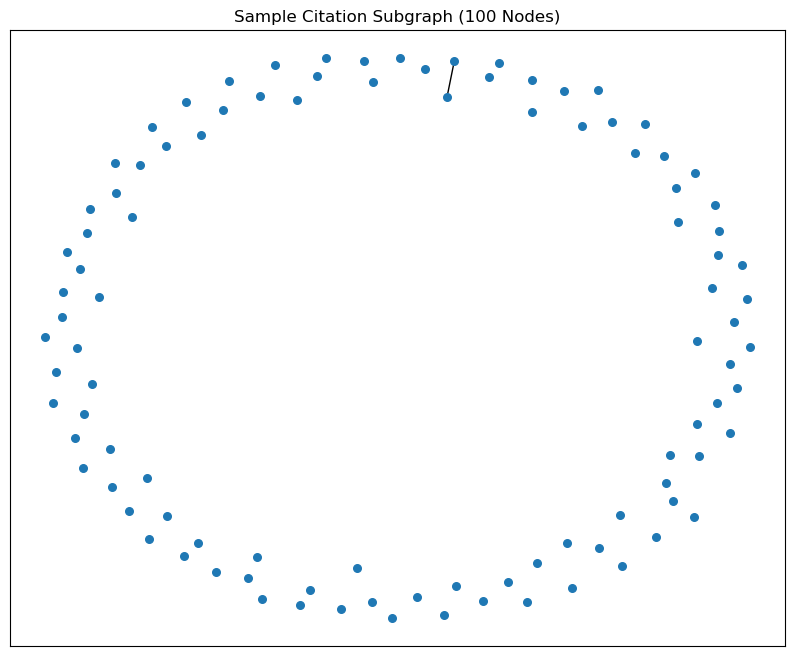


Graph saved successfully as 'citation_graph_filtered.gpickle' (metadata preserved!)


In [5]:
# Small visualization

print("\nVisualizing a small random subgraph (100 nodes)...")
sample_nodes = random.sample(list(G.nodes()), min(100, len(G.nodes())))
H = G.subgraph(sample_nodes)

plt.figure(figsize=(10, 8))
nx.draw_networkx(H, node_size=30, arrows=False, with_labels=False)
plt.title("Sample Citation Subgraph (100 Nodes)")
plt.show()


# Save graph for future tasks
with open("citation_graph_filtered.gpickle", "wb") as f:
    pickle.dump(G, f)

print("\nGraph saved successfully as 'citation_graph_filtered.gpickle' (metadata preserved!)")


## TASK 2

### Importing libraries and configuration

In [6]:
import pickle
import networkx as nx
import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd
import math
import os
from tqdm import tqdm

# ---------- Config ----------
GPICKLE_PATH = "citation_graph_filtered.gpickle"   # <- ensure everyone uses same gpickle
TOP_N = 10
CSV_OUT_DIR = "task2_outputs"
os.makedirs(CSV_OUT_DIR, exist_ok=True)

### Load Graph and setting up Nodes

In [7]:
# ---------- Load graph ----------
print("Loading graph from:", GPICKLE_PATH)
with open(GPICKLE_PATH, "rb") as f:
    G = pickle.load(f)

print("Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())

# ---------- Deterministic node ordering ----------
# Use sorted node ids so everyone gets same index mapping
node_list = sorted(G.nodes())
node_index = {pid: i for i, pid in enumerate(node_list)}
n = len(node_list)
print("Using deterministic node ordering. n =", n)

Loading graph from: citation_graph_filtered.gpickle
Nodes: 49572 Edges: 163309
Using deterministic node ordering. n = 49572


### Build Adjacency and compute Matrices

In [8]:
# ---------- Build adjacency matrix A (rows = citing paper index, cols = cited paper index) ----------
rows = []
cols = []
for u, v in G.edges():
    # Some edges might have nodes not in node_list if gpickle inconsistent; guard against that
    if u in node_index and v in node_index:
        rows.append(node_index[u])
        cols.append(node_index[v])

A = csr_matrix((np.ones(len(rows), dtype=np.int32), (rows, cols)), shape=(n, n), dtype=np.int32)
print("Adjacency matrix built: shape =", A.shape, " nonzeros =", A.nnz)

# ---------- Compute co-citation (C = A^T * A) and bibliographic coupling (B = A * A^T) ----------
print("Computing sparse products: C = A.T @ A (co-citation), B = A @ A.T (bibliographic coupling)")
C = (A.T @ A).tocsr()
B = (A @ A.T).tocsr()
print("Computed. Nonzeros - C:", C.nnz, " B:", B.nnz)

Adjacency matrix built: shape = (49572, 49572)  nonzeros = 163309
Computing sparse products: C = A.T @ A (co-citation), B = A @ A.T (bibliographic coupling)
Computed. Nonzeros - C: 1307415  B: 2469495


### Extract top paper pairs

In [9]:



# ---------- Helper: stable top-pairs extractor ----------
def top_pairs_from_sparse(M, top_n=10, node_list=node_list):
    """
    Return top_n pairs as [((id_i, id_j), score), ...] using deterministic tie-breaking.
    Works on a copy of M to avoid mutating original.
    """
    # Work on a copy (csr) and clear diagonal
    M2 = M.copy().tocsr()
    M2.setdiag(0)
    M2.eliminate_zeros()
    coo = M2.tocoo()

    # Build list of (score, i, j) for i < j to treat pairs unorderedly (symmetric measures)
    pairs = []
    # For large matrices, avoid building huge list if possible: but here we assume the filtered graph is manageable.
    for i, j, v in zip(coo.row, coo.col, coo.data):
        if i < j and v != 0:
            # store negative score for convenience when sorting ascending later
            pairs.append((int(v), i, j))

    # Deterministic sorting: by score desc, then smaller index asc, then larger index asc
    pairs.sort(key=lambda x: (-x[0], x[1], x[2]))

    # Convert to desired output format
    out = [(((node_list[i], node_list[j]), score)) for score, i, j in pairs[:top_n]]
    return out

# ---------- Extract top pairs ----------
print(f"Extracting top-{TOP_N} co-citation pairs...")
top_co = top_pairs_from_sparse(C, top_n=TOP_N)
print(f"Extracting top-{TOP_N} bibliographic-coupling pairs...")
top_bib = top_pairs_from_sparse(B, top_n=TOP_N)

Extracting top-10 co-citation pairs...
Extracting top-10 bibliographic-coupling pairs...


### Results

In [10]:


# ---------- Helper: get title safely ----------
def get_title(pid):
    t = G.nodes[pid].get("title") if pid in G.nodes else None
    if t and str(t).strip():
        return str(t).strip()
    return f"(Title missing) [{pid}]"

# ---------- Pretty print results and save CSVs ----------
def print_and_save(pairs, filename, measure_name):
    rows = []
    print("\n===== Top-{} pairs — {} =====".format(len(pairs), measure_name))
    for idx, ((a, b), score) in enumerate(pairs, start=1):
        ta = get_title(a)
        tb = get_title(b)
        print(f"{idx:2d}. (score={score})")
        print(f"    • {ta}")
        print(f"      ↔ {tb}\n")
        rows.append({
            "rank": idx,
            "paper_id_A": a,
            "title_A": ta,
            "paper_id_B": b,
            "title_B": tb,
            "score": score
        })
    df = pd.DataFrame(rows)
    outpath = os.path.join(CSV_OUT_DIR, filename)
    df.to_csv(outpath, index=False)
    print(f"Saved results to: {outpath}")

print_and_save(top_co, "top_co_citation_pairs.csv", "Co-Citation Score")
print_and_save(top_bib, "top_bib_coupling_pairs.csv", "Bibliographic Coupling Score")

print("\n✅ Task 2 finished. CSV outputs and printed top pairs above.")




===== Top-10 pairs — Co-Citation Score =====
 1. (score=154)
    • Rich Feature Hierarchies for Accurate Object Detection and Semantic Segmentation
      ↔ ImageNet Classification with Deep Convolutional Neural Networks

 2. (score=148)
    • The Pascal Visual Object Classes (VOC) Challenge
      ↔ Object Detection with Discriminatively Trained Part-Based Models

 3. (score=122)
    • Real-time human pose recognition in parts from single depth images
      ↔ Real-time human pose recognition in parts from single depth images

 4. (score=95)
    • Very Deep Convolutional Networks for Large-Scale Image Recognition
      ↔ ImageNet Classification with Deep Convolutional Neural Networks

 5. (score=91)
    • DeCAF: A Deep Convolutional Activation Feature for Generic Visual Recognition
      ↔ ImageNet Classification with Deep Convolutional Neural Networks

 6. (score=91)
    • Caffe: Convolutional Architecture for Fast Feature Embedding
      ↔ ImageNet Classification with Deep Convolution

## TASK 3


### Importing libraries and Load graph

In [11]:
import pickle
import networkx as nx
import numpy as np
from scipy.stats import pearsonr


# Load graph (with metadata)

with open("citation_graph_filtered.gpickle", "rb") as f:
    G = pickle.load(f)

print(" Graph loaded! Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())


# Compute in-degree (citations in the extracted subset)

cit_counts = dict(G.in_degree())

 Graph loaded! Nodes: 49572 Edges: 163309


### Page rank and correlation analysis

In [12]:


# Loop over damping factors

alphas = np.arange(0.15, 0.96, 0.10)
results = {}
k = 50

for alpha in alphas:
    pr = nx.pagerank(G, alpha=alpha)
    # Sort nodes by PageRank
    top_pr = sorted(pr.items(), key=lambda x: x[1], reverse=True)[:k]
    top_nodes = [n for n, _ in top_pr]

    # Extract corresponding citation counts
    pr_scores = [pr[n] for n in top_nodes]
    citations = [cit_counts.get(n, 0) for n in top_nodes]

    # Pearson correlation
    corr, _ = pearsonr(pr_scores, citations)
    results[round(alpha, 2)] = corr
    print(f"d={alpha:.2f} → Pearson correlation = {corr:.6f}")

# -----------------------------------------
# 4️⃣ Identify best and worst damping factors
# -----------------------------------------
best_alpha = max(results, key=results.get)
worst_alpha = min(results, key=results.get)
print("\nBest d:", best_alpha, " (corr =", results[best_alpha], ")")
print("\nWorst d:", worst_alpha, " (corr =", results[worst_alpha], ")")

d=0.15 → Pearson correlation = 0.785755
d=0.25 → Pearson correlation = 0.768759
d=0.35 → Pearson correlation = 0.745674
d=0.45 → Pearson correlation = 0.732333
d=0.55 → Pearson correlation = 0.712790
d=0.65 → Pearson correlation = 0.688880
d=0.75 → Pearson correlation = 0.674215
d=0.85 → Pearson correlation = 0.554154
d=0.95 → Pearson correlation = 0.640048

Best d: 0.15  (corr = 0.7857552818011266 )

Worst d: 0.85  (corr = 0.5541540806284978 )


### Top papers and summary

In [13]:
#  Helper to print top-10 papers

def get_title(pid):
    return G.nodes[pid].get("title", pid)

def top_papers(alpha):
    pr = nx.pagerank(G, alpha=alpha)
    top = sorted(pr.items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"\n===== 🔝 Top-10 Papers (α={alpha:.2f}) =====")
    print(f"{'S.No.':<5} {'Title':<70} {'PageRank Score'}")
    for i, (pid, score) in enumerate(top, 1):
        print(f"{i:<5} {get_title(pid)[:70]:<70} {score:.6f}")


# Show top papers for best and worst α

top_papers(best_alpha)
top_papers(worst_alpha)


# Correlation summary table

print("\n=====  Correlation Summary =====")
print(f"{'Damping Factor':<15} {'Pearson Correlation'}")
for a, c in results.items():
    print(f"{a:<15} {c:.6f}")

print("\n Task 3 completed successfully!")



===== 🔝 Top-10 Papers (α=0.15) =====
S.No. Title                                                                  PageRank Score
1     LIBSVM: A library for support vector machines                          0.000848
2     The Pascal Visual Object Classes (VOC) Challenge                       0.000275
3     Object Detection with Discriminatively Trained Part-Based Models       0.000223
4     Community detection in graphs                                          0.000160
5     Fast and Scalable Local Kernel Machines                                0.000146
6     What is Twitter, a social network or a news media?                     0.000143
7     Reducibility Among Combinatorial Problems                              0.000131
8     Talking about tactile experiences                                      0.000110
9     ImageNet Classification with Deep Convolutional Neural Networks        0.000103
10    KEGG for representation and analysis of molecular networks involving d 0.000100

===== 🔝 T

## TASK 4



###  Theoretical Comparison 
**Normal PageRank**:
   - Uniform random surfer model.
   - All nodes are treated equally — teleportation probability is uniform.
   - PageRank(G, alpha=d): pr = d * A' * pr + (1-d) * 1/N

**Topic-Sensitive PageRank**:
   - Biased random surfer model.
   - Teleportation happens only to nodes related to a specific topic.
   - A separate PageRank vector is computed per topic.
   - Used for domain-specific ranking (e.g., “security papers”).

**Personalized PageRank**:
   - Similar to topic-sensitive, but personalization vector depends on a *user* or *set of preferred nodes*.
   - Used for recommendations (e.g., user-specific content).



### Importing libraries and load Graph

In [14]:
import pickle
import networkx as nx
import numpy as np



#  Load graph

with open("citation_graph_filtered.gpickle", "rb") as f:
    G = pickle.load(f)

print("Graph loaded! Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())

Graph loaded! Nodes: 49572 Edges: 163309


### Topic sensitive Page Rank Algorithm

In [15]:
# Define topics

topics = ["security", "hashing", "streaming", "timeseries", "search"]
damping = 0.85


#  Precompute citations (in-degree)

cit_counts = dict(G.in_degree())

#  Helper functions

def get_title(pid):
    return G.nodes[pid].get("title", pid)

def topic_sensitive_pagerank(G, topic, alpha=0.85):
    topic_nodes = [n for n, data in G.nodes(data=True)
                   if topic.lower() in data.get("title", "").lower()]
    
    if not topic_nodes:
        print(f" No papers found for topic: {topic}")
        return None, []

    # Create personalization vector (teleportation only to topic-relevant nodes)
    p = {n: 1.0 / len(topic_nodes) if n in topic_nodes else 0.0 for n in G.nodes()}
    pr = nx.pagerank(G, alpha=alpha, personalization=p)
    return pr, topic_nodes

def show_top_papers_for_topic(topic, top_n=10):
    pr, topic_nodes = topic_sensitive_pagerank(G, topic, damping)
    if pr is None:
        return

    # Sort by PageRank score
    top = sorted(pr.items(), key=lambda x: x[1], reverse=True)[:top_n]

    print(f"\n=====  Top-10 Papers for Topic: {topic.capitalize()} =====")
    print(f"{'S.No.':<5} {'Title':<70} {'PageRank Score':<18} {'Citations'}")
    for i, (pid, score) in enumerate(top, 1):
        print(f"{i:<5} {get_title(pid)[:70]:<70} {score:<18.6e} {cit_counts.get(pid, 0)}")







### Results

In [16]:
#  Run for all topics
for topic in topics:
    show_top_papers_for_topic(topic)

print("\n Task 4 completed successfully!")


=====  Top-10 Papers for Topic: Security =====
S.No. Title                                                                  PageRank Score     Citations
1     Security and Privacy Challenges in Cloud Computing Environments        8.956396e-03       33
2     Neutralization: new insights into the problem of employee systems secu 8.016105e-03       21
3     SecureCloud: Towards a Comprehensive Security Framework for Cloud Comp 7.317813e-03       3
4     Enabling Public Auditability and Data Dynamics for Storage Security in 6.750305e-03       47
5     Dependable and Secure Sensor Data Storage with Dynamic Integrity Assur 6.745501e-03       3
6     Stackelberg vs. Nash in security games: interchangeability, equivalenc 6.059331e-03       8
7     A lattice-based approach to mashup security                            5.658768e-03       8
8     Google Android: A Comprehensive Security Assessment                    5.487063e-03       22
9     Permissive dynamic information flow analysis        